In [15]:
import torch #Pytorch
from torchvision import datasets # Dataset Modules from torch
import torchvision.transforms as transforms # Image Transforms
from torch.utils.data.sampler import SubsetRandomSampler #Sampler
import torch.nn as nn #Torch framework containing the NN layers
import torch.nn.functional as F # This is where we will get our activation function from
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt

# Before we can implement the CNN we need to deal with how we are going to load our training/testing dataset into the CNN. This is done through
# DATA PIPELINES:

#If we are loading EXISTING datasets from pytorch, such as MNIST, then we can just do:

#1. Encoding the data into tensor so that it can be operated on by the NN:
transform = transforms.ToTensor()

#2. Splitting the data into training and testing datasets (Usually 80/20 split):

train_data = datasets.MNIST(root='data', train= True,
                            download= True, transform= transform)
test_data = datasets.MNIST(root= 'data', train= False,
                           download=True, transform= transform)

#Printing the train and test data gives:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [2]:
# So we have 60k training datapoints and 10k which will be used for evluation: looking at the size of our training data we can see that:
print(train_data.data.size())
# Meaning that the dataset is comprised of 60k 28x28 images (datapoints)

torch.Size([60000, 28, 28])


In [7]:
# Now we need to split the data into 80/20 split for each subcategory: 
# We create a list of indices of the training data:
num_train = len(train_data)
print("The number of indices for training data =", num_train)
indices = list(range(num_train))
print("The len of the indices is", len(indices))

The number of indices for training data = 60000
The len of the indices is 60000


In [8]:
# Then we randomly shuffle the indices:
np.random.shuffle(indices)

# Before slicing them in an 80/20 split:
valid_size = 0.2
split = int(np.floor(valid_size*num_train))
train_idx = indices[split:] # Slicing the last 80% for training
valid_idx = indices[:split] # Slicing the first 20% for validation data

print("Number of training indices = ", len(train_idx))
print("Number of valid indices =", len(valid_idx))

Number of training indices =  48000
Number of valid indices = 12000


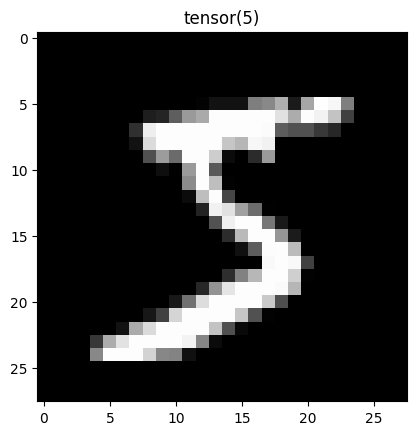

In [3]:
#We can check what one of the datapoints looks like by using the plt function:
plt.imshow(train_data.data[0], cmap= 'gray') #Plotting the first element of the dataset
plt.title(train_data.targets[0]) # Adding the label as the title
plt.show()

In [4]:
# Before we load our data into the CNN we need to set up the CNN first:

# Our nerual netowrk will inherit from the nn.module from torch:

class MNISTmodel1(nn.Module):
    # Now we need to define what our neural network looks like (Arhcitecture):
    def __init__(self):
        super(MNISTmodel1, self).__init__() # Initialising the module
    # We know that our input comes in as a 1x28x28 array, so the output(Convolutional layer) should also have a shape of 28x28 so that info is not lost:
    # The formula for the shape of the Convolutional later is given by:
    #Shape of a Convolutional Layer = (W - K + 2P)
    #                                  ------------ + 1
    #                                       S
    # where, 
    #       W = Width/Height of previous layer = 28
    #       K = Filter Size = 3 , kernal size = 3x3
    #       P = Padding = 0, how many pixels are we gonna around our input when scanning with the kernal
    #       S = Stride = 1(default), the step, ie we are scanning one pixel at a time
    #
    # Therefore, 
    #           if padding = 0
    #           Output Shape = ((28 - 3 + 2*0)/1)+1 = 26 
    # We want the dimensions to stay the same so that there is no 
    # loss of information when performing the convolution. 
    # Hence, 
    #       if padding = 1
    #       Output Shape = ((28 - 3 + 2*1)/1)+1 = 28

    # So we define our first convolutional layer as:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # Second layer, takes the input from the first layer and outputs 16x28x28 (Not sure how # of out channels is determined)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

    # Now we can flatten the output from our Convolution layers and input them into our NN:
    # The first layer of our neural network would have to be a 1-dimnesional array so it should see : 16x28x28 = 12544 inputs, and thus 12544 nodes:
        self.linear1 = nn.Linear(in_features=12544, out_features=256)
    # The second layer would have 256 neurons since it takes 256 input weights from the first layer:
        self.linear2 = nn.Linear(in_features=256, out_features=64)
    # For this NN we are only having 3 layers so the last linear layer would be our output layer and thus should only contain 10 neurons since we are
    # classifying 10 digits:
        self.linear3 = nn.Linear(in_features=64, out_features=10)

    # For neural netowrks there is something called the Dropout ( Do some research boi), basically it ensures that during forward/backward propagation,
    # there is a probability p, of the neurons being "dropped" in every interation. IDK why this is done btw, need to learn something.
        self.dropout = nn.Dropout(p=0.25) #25% chance of neurons being dropped at each iteration.

#Now we have to define the forward behaviour, ie the what kind of activation functions are used ( sigmoid, Relu etc):

    def forward(self, image_batch):
        image_batch = F.relu(input=self.conv1(image_batch)) # Passing the image batches through first convolutoinal layer
        image_batch = F.relu(input=self.conv2(image_batch)) # Passing it through the second 

        # Before we can pass the output of the second layer to our linear layers we need to flatten it into 1-d, this can be done using torch methods:
        flat_image_batch = image_batch.view(image_batch.shape[0], -1) # Flattening
        flat_image_batch = F.relu(input=self.linear1(flat_image_batch)) #Passing it though the first linear layer

        # Passing it through the second linear layer , and adding the dropout function:
        flat_image_batch = self.dropout(F.relu(input= self.linear2(flat_image_batch)))
        flat_image_batch = F.relu(input=self.linear3(flat_image_batch)) # Passing through the last linear layer before getting the output

        return flat_image_batch


    

In [5]:
# Ok now that the CNN is setup already we can use torchsummary to look at what we are actually doing:
from torchsummary import summary

# Then we have to choose whether we want to run it on the GPU ( with CUDA ) or on the CPU:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The model is running on",device)

# Now we initalize the model:
mnist1 = MNISTmodel1().to(device)
summary(model=mnist1, input_size=(1,28,28), batch_size=20) # We are sending in 20 datapoints at a time

The model is running on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


In [20]:
# Ok now that we've done the bifucation of the data, set up the training model, we can load the training data into the model through something called:
# DataLoaders (a class in pytorch)
from torch.utils.data.dataloader import DataLoader

# First we have to sample our data to obtain training and validation batches(batch number can be defined):
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Then we load them using the built-in dataloader class:
num_workers = 0 # Num_workers tells the data loader instance how many sub-processes to use for data loading. If the num_worker is zero (default) the GPU has to weight for CPU to load data. Theoretically, greater the num_workers, more efficiently the CPU load data and less the GPU has to wait
batch_size = 20 # How many datapoints to load per batch.

# Now we can define and load our training and validation sets (Note that the dataset used for both is train_data, since that is where we are loading from.)
train_loader = DataLoader(dataset= train_data, batch_size=20, sampler=train_sampler, num_workers=num_workers) 

valid_loader = DataLoader(dataset=train_data, batch_size=20, sampler=valid_sampler, num_workers=num_workers)

# Now recall that we still have 10k datapoints from before which we will use for the test set: 
test_loader = DataLoader(dataset= test_data, batch_size=batch_size, num_workers=num_workers) # We don't need to sample here since we are testing the data




In [21]:
# We can check that the dataloaders are working properly by plotting them out:

dataiterator = iter(train_loader) # Get the whole batch 
images, labels = next(dataiterator) # Extract the images and their labels 
print(len(images), len(labels)) # Should be equal to the batch size, 20
print('Correct Labels: ', labels)
images = images.numpy() # Convert the images to numpy array for matplotlib
print('Shape of our images tensor =', images.shape)
print('Batch Size =', images.shape[0], 'Image Height/Width =', \
                                                        images.shape[2])

print()
print('Squeezing the images tensor =', np.squeeze(images).shape)
print('Un-squeezing the images tensor (axis=3) =', \
                                        np.expand_dims(images, axis=3).shape)

20 20
Correct Labels:  tensor([5, 7, 0, 2, 3, 3, 7, 4, 6, 3, 6, 6, 0, 6, 1, 7, 3, 1, 8, 1])
Shape of our images tensor = (20, 1, 28, 28)
Batch Size = 20 Image Height/Width = 28

Squeezing the images tensor = (20, 28, 28)
Un-squeezing the images tensor (axis=3) = (20, 1, 28, 1, 28)


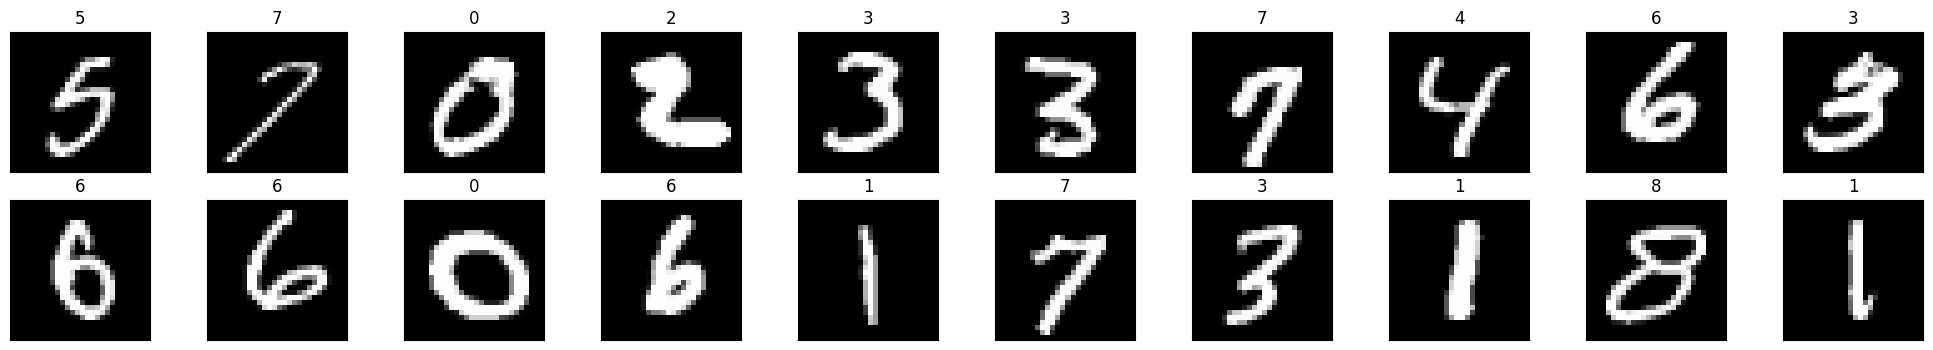

In [22]:
# Plotting our batch :

# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(20)
for idx in np.arange(20):
    # Add a subplot for the image 
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    # Populate the subplot with the image 
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


In [23]:
# Now it's actually time to train our model: This is done using an additional pytorch lib called poutyne.

from poutyne.framework import Model # Core datastucture for poutyne
from torch import optim # importing our optimizers
from poutyne.framework import ModelCheckpoint # Saves trained model during training?
from poutyne.framework import EarlyStopping # Something used to prevent overfitting of the model, a stop for the optimizer I guess?

# Now we use poutyne to define a training function for our model:
learning_rate = 0.1
epochs = 10 # Number of times the model will go through the training dataset
def poutyne_train(model_name, pytorch_model):
    callbacks = [
        # Saving the latest weights
        ModelCheckpoint(model_name + "_last_epoch.ckpt", temporary_filename= "last_epoch.ckpt.tmp"),

        EarlyStopping(monitor="val_acc", patience=0, verbose= True, mode= 'max'),

        
    ]

    #Choosing the optimizer functions and loss functions:
    optimizer = optim.SGD(pytorch_model.parameters(), lr= learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Creating the Poutyne training model:
    model = Model(pytorch_model, optimizer=optimizer, loss_function=loss_function, batch_metrics=["Accuracy"])
    
    # Sending the model to the training devide, GPU/CPU
    model.to(device)

    # Training the model:
    model.fit_generator(train_loader, valid_loader, epochs=epochs, callbacks=callbacks) # Getting the data from our loaders that we defined earlier

    # Finally testing the trained model:
    test_loss, test_acc = model.evaluate_generator(test_loader) # Testing the model using our test data from the test loader
    print(f"Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}")

    return None








In [24]:
# Now we can finally train and test our model! Just call the function that we defined above and specify which model we are using:

poutyne_train(model_name='mnist1', pytorch_model=mnist1)

Epoch:  1/10 Train steps: 2400 Val steps: 600 41.54s loss: 0.315912 acc: 90.350000 val_loss: 0.110647 val_acc: 96.741667
Epoch:  2/10 Train steps: 2400 Val steps: 600 41.38s loss: 0.082882 acc: 97.695833 val_loss: 0.079682 val_acc: 97.825000
Epoch:  3/10 Train steps: 2400 Val steps: 600 43.57s loss: 0.050392 acc: 98.514583 val_loss: 0.069065 val_acc: 98.033333
Epoch:  4/10 Train steps: 2400 Val steps: 600 42.00s loss: 0.035145 acc: 98.937500 val_loss: 0.061850 val_acc: 98.300000
Epoch:  5/10 Train steps: 2400 Val steps: 600 42.61s loss: 0.025442 acc: 99.250000 val_loss: 0.058922 val_acc: 98.408333
Epoch:  6/10 Train steps: 2400 Val steps: 600 42.29s loss: 0.019255 acc: 99.404167 val_loss: 0.065939 val_acc: 98.491667
Epoch:  7/10 Train steps: 2400 Val steps: 600 42.40s loss: 0.013425 acc: 99.575000 val_loss: 0.067809 val_acc: 98.500000
Epoch:  8/10 Train steps: 2400 Val steps: 600 42.21s loss: 0.011693 acc: 99.639583 val_loss: 0.064191 val_acc: 98.716667
Epoch:  9/10 Train steps: 2400 V